In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier
import shap
import matplotlib.pyplot as plt
import random

shap.initjs()

In [2]:
# ============================
# 1. Load cleaned data
# ============================

data_path = "./data/processed/financial_report_bank_zscore_clean.csv"
df = pd.read_csv(data_path)

print("Shape data:", df.shape)
print(df.head())
df.head()

Shape data: (1812, 27)
  symbol  calendar_year period    time       size       der       dar  \
0   AGRO           2023     Q4  2023Q4  30.151990  0.158755  0.043646   
1   AGRO           2023     Q3  2023Q3  30.067564  0.027119  0.008067   
2   AGRO           2023     Q2  2023Q2  30.116618  0.033987  0.009662   
3   AGRO           2023     Q1  2023Q1  30.168138  0.033731  0.009062   
4   AGRO           2022     Q4  2022Q4  30.262822  0.032612  0.007952   

        roa       roe      sdoa  ...  operating_income_ratio  quarter  \
0  0.000778  0.002830  0.000161  ...               -0.070020        4   
1  0.000472  0.001587  0.000052  ...                0.109110        3   
2  0.000408  0.001436  0.000891  ...                0.748114        2   
3  0.000346  0.001287  0.001173  ...                0.859516        1   
4 -0.001512 -0.006200  0.001532  ...                0.531961        4   

   equity_to_assets  roa_std_bank  bank_zscore  roa_count_bank  mask_bad  \
0          0.956354    

,symbol,calendar_year,period,time,size,der,dar,roa,roe,sdoa,...,operating_income_ratio,quarter,equity_to_assets,roa_std_bank,bank_zscore,roa_count_bank,mask_bad,bank_zscore_clean,bank_zscore_risk_label,bank_zscore_risk
0,AGRO,2023,Q4,2023Q4,30.151990,0.158755,0.043646,0.000778,0.002830,0.000161,...,-0.070020,4,0.956354,0.018465,51.835988,40,False,51.835988,2.0,1
1,AGRO,2023,Q3,2023Q3,30.067564,0.027119,0.008067,0.000472,0.001587,0.000052,...,0.109110,3,0.991933,0.018465,53.746257,40,False,53.746257,2.0,1
2,AGRO,2023,Q2,2023Q2,30.116618,0.033987,0.009662,0.000408,0.001436,0.000891,...,0.748114,2,0.990338,0.018465,53.656465,40,False,53.656465,2.0,1
3,AGRO,2023,Q1,2023Q1,30.168138,0.033731,0.009062,0.000346,0.001287,0.001173,...,0.859516,1,0.990938,0.018465,53.685576,40,False,53.685576,2.0,1
4,AGRO,2022,Q4,2022Q4,30.262822,0.032612,0.007952,-0.001512,-0.006200,0.001532,...,0.531961,4,0.992048,0.018465,53.645055,40,False,53.645055,2.0,1


In [3]:
# ============================
# 2. Filter data tahun (tidak pakai 2024 yang incomplete)
# ============================
YEAR_START = 2014
YEAR_END   = 2023

df = df[df["calendar_year"].between(YEAR_START, YEAR_END)].copy()

# Kalau df kamu sudah yearly (1 row per bank-year), bagian ini boleh di-skip
if "symbol" in df.columns and "period" in df.columns:
    ok_pairs = (
        df.groupby(["symbol", "calendar_year"])["period"]
          .nunique()
          .reset_index(name="n_quarters")
          .query("n_quarters == 4")[["symbol", "calendar_year"]]
    )
    df = df.merge(ok_pairs, on=["symbol", "calendar_year"], how="inner")

# ============================
# 3. Pilih fitur & target
# ============================

feature_cols = [
    "size",
    "der", "dar",
    "roa", "roe",
    "sdoa", "sdroe",
    "tobinq",
    "ppe",
    "cash",
    "ar",
    "log_sales",
    "sgr",
    "operating_income_ratio",
    "equity_to_assets"
]

target_col = "bank_zscore_risk"

# Buang baris yang ada NaN di fitur/target
df_model = df.dropna(subset=feature_cols + [target_col]).copy()

X = df_model[feature_cols]
y = df_model[target_col].astype(int)

print("Data used years:", df_model["calendar_year"].min(), "-", df_model["calendar_year"].max())
print("Total rows:", len(df_model), "| Positive rate:", round(y.mean(), 4))

Data used years: 2014 - 2023
Total rows: 1812 | Positive rate: 0.2445


In [4]:
# Label per Horizon

MAX_HORIZON = 5

df_h = df_model.sort_values(["symbol", "calendar_year"]).copy()

for h in range(1, MAX_HORIZON + 1):
    df_h[f"distress_{h}y"] = (
        df_h.groupby("symbol")["bank_zscore_risk"]
            .shift(-h)
    )

df_h.head()

,symbol,calendar_year,period,time,size,der,dar,roa,roe,sdoa,...,roa_count_bank,mask_bad,bank_zscore_clean,bank_zscore_risk_label,bank_zscore_risk,distress_1y,distress_2y,distress_3y,distress_4y,distress_5y
36,AGRO,2014,Q4,2014Q4,29.485003,0.163192,0.035647,0.003419,0.024146,0.000710,...,40,False,52.412198,2.0,1,1.0,1.0,1.0,1.0,1.0
37,AGRO,2014,Q3,2014Q3,29.414072,0.163192,0.035647,0.001679,0.011505,0.000584,...,40,False,52.318001,2.0,1,1.0,1.0,1.0,1.0,1.0
38,AGRO,2014,Q2,2014Q2,29.370668,0.163192,0.035647,0.002572,0.017084,0.001346,...,40,False,52.366372,2.0,1,1.0,1.0,1.0,1.0,1.0
39,AGRO,2014,Q1,2014Q1,29.276297,0.163192,0.035647,0.003093,0.018537,0.002200,...,40,False,52.394569,2.0,1,1.0,1.0,1.0,1.0,1.0
32,AGRO,2015,Q4,2015Q4,29.755018,0.163192,0.035647,0.003282,0.020299,0.000690,...,40,False,52.404806,2.0,1,1.0,1.0,1.0,1.0,1.0


In [5]:
# ============================
# GRADIENT BOOSTING FUNCTIONS
# ============================

import xgboost as xgb
import lightgbm as lgb


from ngboost import NGBoost
from ngboost.distns import Bernoulli
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, roc_auc_score,
    average_precision_score,
    precision_recall_curve
)

TRAIN_END_YEAR = 2019
VAL_END_YEAR = 2021

MODEL_TITLE_MAP = {
    "rf": "Random Forest",
    "xgb": "XGBoost",
    "lgbm": "LightGBM",
    "ngboost": "NGBoost"
}


def build_threshold_table(y_true, proba):
    precision, recall, thresholds = precision_recall_curve(y_true, proba)

    rows = []
    for thr in thresholds:
        pred = (proba >= thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, pred).ravel()

        rows.append({
            "threshold": thr,
            "recall": tp / (tp + fn) if (tp + fn) > 0 else np.nan,
            "precision": tp / (tp + fp) if (tp + fp) > 0 else np.nan,
            "type_i_error": fn / (fn + tp) if (fn + tp) > 0 else np.nan,
            "type_ii_error": fp / (fp + tn) if (fp + tn) > 0 else np.nan,
        })

    return pd.DataFrame(rows)


def choose_threshold_max_type1(
    y_true,
    proba,
    max_type1=0.25
):
    thr_df = build_threshold_table(y_true, proba)

    feasible = thr_df[thr_df["type_i_error"] <= max_type1]

    if feasible.empty:
        print("No threshold satisfies Type I constraint")
        return None

    # pilih threshold PALING BESAR (paling konservatif)
    best_row = feasible.sort_values("threshold", ascending=False).iloc[0]

    return best_row["threshold"], best_row


def train_boosting_for_horizon(
    df,
    feature_cols,
    horizon,
    train_end_year,
    val_end_year,
    model_name="xgb",     # "xgb", "lgbm", "ngboost"
    recall_target=0.75,
    model_params=None
):
    print(f"\n===== TRAIN {model_name.upper()} {horizon}Y =====")

    # ============================
    # Prepare data
    # ============================
    df_hh = df.dropna(subset=[f"distress_{horizon}y"]).copy()

    y = df_hh[f"distress_{horizon}y"].astype(int)
    X = df_hh[feature_cols]

    train_mask = df_hh["calendar_year"] <= train_end_year
    val_mask   = (df_hh["calendar_year"] > train_end_year) & \
                 (df_hh["calendar_year"] <= val_end_year)
    test_mask  = df_hh["calendar_year"] > val_end_year

    X_train, y_train = X[train_mask], y[train_mask]
    X_val, y_val     = X[val_mask], y[val_mask]
    X_test, y_test   = X[test_mask], y[test_mask]

    # ============================
    # Cost-sensitive weights
    # ============================
    pos = (y_train == 1).sum()
    neg = (y_train == 0).sum()

    sample_weight = np.where(y_train == 1, neg / pos, 1.0)

    # ============================
    # Train model
    # ============================
    if model_name == "lgbm":
        if model_params is None:
            model_params = {
                "objective": "binary",
                "learning_rate": 0.03,
                "num_leaves": 31,
                "max_depth": -1,
                "subsample": 0.8,
                "colsample_bytree": 0.8,
                "scale_pos_weight": neg / pos,
                "random_state": 42
            }

        lgb_train = lgb.Dataset(X_train, y_train, weight=sample_weight)
        lgb_val   = lgb.Dataset(X_val, y_val, reference=lgb_train)

        booster = lgb.train(
            model_params,
            lgb_train,
            num_boost_round=2000,
            valid_sets=[lgb_val],
            callbacks=[
                lgb.early_stopping(stopping_rounds=200),
                lgb.log_evaluation(period=0)
            ]
        )

        proba_val = booster.predict(X_val)
        model_obj = booster

    # ----------------------------
    elif model_name == "ngboost":
        if model_params is None:
            model_params = {
                "n_estimators": 500,
                "learning_rate": 0.03,
                "random_state": 42
            }

        ngb = NGBoost(
            Dist=Bernoulli,
            **model_params
        )

        ngb.fit(X_train, y_train, sample_weight=sample_weight)

        # NGBoost outputs distribution → ambil mean prob
        proba_val = ngb.predict_proba(X_val)[:, 1]
        model_obj = ngb

    else:
        raise ValueError("model_name must be 'xgb', 'lgbm', or 'ngboost'")

    # ============================
    # Threshold tuning (VAL)
    # ============================
    thr_df = build_threshold_table(y_val, proba_val)
    feasible = thr_df[thr_df["recall"] >= recall_target]

    if feasible.empty:
        print("⚠️ No threshold meets recall target")
        chosen_thr = 0.5
    else:
        chosen_thr = feasible.sort_values("threshold").iloc[0]["threshold"]

    print("Chosen threshold:", round(chosen_thr, 4))

    return {
        "model_name": model_name,
        "horizon": horizon,
        "model": model_obj,
        "threshold": chosen_thr,
        "X_train": X_train,
        "y_train": y_train,
        "X_test": X_test,
        "y_test": y_test
    }



def calc_type_errors(y_true, y_proba, thr=0.5):
    y_pred = (y_proba >= thr).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    type1_error = fn / (tp + fn) if (tp + fn) > 0 else np.nan
    type2_error = fp / (tn + fp) if (tn + fp) > 0 else np.nan

    return {
        "Type_I_error": type1_error,   # FAILED → predicted NON-FAILED
        "Type_II_error": type2_error,  # NON-FAILED → predicted FAILED
        "TP": tp, "FN": fn, "FP": fp, "TN": tn,
        "Recall": tp / (tp + fn) if (tp + fn) > 0 else np.nan
    }


def evaluate_rf_model(model_dict, name=None):
    rf = model_dict["model"]
    X_test = model_dict["X_test"]
    y_test = model_dict["y_test"]
    thr = model_dict["threshold"]

    name = name or f"TEST {model_dict['horizon']}Y"

    proba = rf.predict_proba(X_test)[:, 1]
    pred = (proba >= thr).astype(int)

    print(f"\n=== {name} (thr={thr:.4f}) ===")
    print("Accuracy :", accuracy_score(y_test, pred))
    print("ROC-AUC  :", roc_auc_score(y_test, proba))
    print("PR-AUC   :", average_precision_score(y_test, proba))
    print("Confusion Matrix:\n", confusion_matrix(y_test, pred))
    print(classification_report(y_test, pred, digits=4))


def eval_gb_split(
    name,
    model,
    X,
    y,
    thr=0.4,
    model_type="xgb"   # "xgb", "lgbm", "ngboost"
):
    """
    Unified evaluation for:
    - XGBoost Booster
    - LightGBM Booster
    - NGBoost
    """

    # ============================
    # Get probabilities
    # ============================
    if model_type == "xgb":
        # XGBoost Booster
        if isinstance(X, xgb.DMatrix):
            proba = model.predict(X)
        else:
            proba = model.predict(xgb.DMatrix(X))

    elif model_type == "lgbm":
        # LightGBM Booster
        proba = model.predict(X)

    elif model_type == "ngboost":
        # NGBoost (sklearn-style)
        proba = model.predict_proba(X)[:, 1]

    else:
        raise ValueError("model_type must be 'xgb', 'lgbm', or 'ngboost'")

    # ============================
    # Predictions
    # ============================
    pred = (proba >= thr).astype(int)

    # ============================
    # Metrics
    # ============================
    auc = roc_auc_score(y, proba) if len(np.unique(y)) > 1 else np.nan
    pr  = average_precision_score(y, proba) if len(np.unique(y)) > 1 else np.nan
    acc = accuracy_score(y, pred)

    print(f"\n=== {name} (thr={thr}) ===")
    print("Accuracy :", acc)
    print("ROC-AUC  :", auc)
    print("PR-AUC   :", pr)
    print("Confusion matrix:\n", confusion_matrix(y, pred))
    print(classification_report(y, pred, digits=4))

    err = calc_type_errors(y, proba, thr)
    print("Type I Error :", err["Type_I_error"])
    print("Type II Error:", err["Type_II_error"])
    print("Recall       :", err["Recall"])

    return {
        "accuracy": acc,
        "roc_auc": auc,
        "pr_auc": pr,
        "type_I_error": err["Type_I_error"],
        "type_II_error": err["Type_II_error"],
        "recall": err["Recall"],
        "threshold": thr
    }


def plot_shap_for_horizon(
    model_dict, 
    feature_cols, 
    model_type="rf",   # "rf", "xgb", "lgbm"
    sample_n=500, 
    plot_type="bar"
):
    rf = model_dict["model"]
    X_train = model_dict["X_train"]

    X_sample = X_train.sample(
        n=min(sample_n, len(X_train)),
        random_state=42
    )

    if model_type == "xgb":
        booster = model_dict["booster"]
        dshap = xgb.DMatrix(X_sample)

        explainer = shap.TreeExplainer(booster)
        shap_values = explainer.shap_values(dshap)

        title_prefix = "XGBoost"

    elif model_type == "lgbm":
        booster = model_dict["model"]  # lgb booster

        explainer = shap.TreeExplainer(booster)
        shap_values_raw = explainer.shap_values(X_sample)

        # LightGBM binary → kadang list, kadang array
        if isinstance(shap_values_raw, list):
            shap_values = shap_values_raw[1]  # class distress
        else:
            shap_values = shap_values_raw

        title_prefix = "LightGBM"

    elif model_type in ["rf", "gb"]:
        model = model_dict["model"]

        explainer = shap.TreeExplainer(model)
        shap_values_raw = explainer.shap_values(X_sample)

        # Binary classification:
        # ambil class = 1 (distress)
        # shap_values = shap_values_all[1]

        if isinstance(shap_values_raw, list):
            # multiclass / probabilistic output
            shap_values = shap_values_raw[1]  # class distress
        else:
            # already (n_samples, n_features)
            shap_values = shap_values_raw

        title_prefix = "Random Forest" if model_type == "rf" else "Gradient Boosting"

    elif model_type == "ngboost":
        raise NotImplementedError(
            "NGBoost is not compatible with SHAP TreeExplainer. "
            "Interpretability should rely on feature importance or sensitivity analysis."
        )
        
    else:
        raise ValueError("model_type must be 'rf', 'xgb', or 'lgbm'")

    
    if not isinstance(shap_values, np.ndarray) or shap_values.ndim != 2:
        raise ValueError(
            f"SHAP values must be 2D array (n_samples, n_features), got {type(shap_values)} {getattr(shap_values, 'shape', None)}"
        )
    
    # shap_values[1] → class distress
    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        shap_values,
        X_sample,
        feature_names=feature_cols,
        plot_type=plot_type,
        show=False
    )
    model_name = MODEL_TITLE_MAP.get(model_type, model_type.upper())
    plt.title(f"{model_name} Summary – {model_dict['horizon']}Y Horizon")
    plt.tight_layout()
    plt.show()

In [6]:
# ============================
# LIGHT GBM TRAINING
# ============================
gb_models = {}

for h in [1, 2, 3, 4, 5]:
    gb_models[h] = train_boosting_for_horizon(
        df=df_h,
        feature_cols=feature_cols,
        horizon=h,
        train_end_year=TRAIN_END_YEAR,
        val_end_year=VAL_END_YEAR,
        model_name="lgbm"
    )


===== TRAIN LGBM 1Y =====
[LightGBM] [Info] Number of positive: 261, number of negative: 815
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3809
[LightGBM] [Info] Number of data points in the train set: 1076, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[205]	valid_0's binary_logloss: 0.283771
Chosen threshold: 0.001

===== TRAIN LGBM 2Y =====
[LightGBM] [Info] Number of positive: 262, number of negative: 814
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000985 seconds.
You can set `force_col_wise=true` to remove the o

In [7]:
gb_models

{1: {'model_name': 'lgbm',
  'horizon': 1,
  'model': <lightgbm.basic.Booster at 0x7ffecaa57490>,
  'threshold': 0.0010261969757715517,
  'X_train':            size       der       dar       roa       roe      sdoa     sdroe  \
  36    29.485003  0.163192  0.035647  0.003419  0.024146  0.000710  0.005172   
  37    29.414072  0.163192  0.035647  0.001679  0.011505  0.000584  0.003031   
  38    29.370668  0.163192  0.035647  0.002572  0.017084  0.001346  0.008377   
  39    29.276297  0.163192  0.035647  0.003093  0.018537  0.002200  0.012384   
  32    29.755018  0.163192  0.035647  0.003282  0.020299  0.000690  0.005316   
  ...         ...       ...       ...       ...       ...       ...       ...   
  1795  30.969818  0.362714  0.080535  0.005377  0.024216  0.000677  0.003221   
  1788  31.240215  1.157043  0.217260  0.002111  0.011244  0.000827  0.004737   
  1789  31.296269  1.247369  0.218797  0.003120  0.017785  0.000626  0.002238   
  1790  31.245035  1.339360  0.242862  0.00


=== TEST 1Y (thr=0.4) ===
Accuracy : 0.8260869565217391
ROC-AUC  : 0.8937053383774696
PR-AUC   : 0.6972429468060236
Confusion matrix:
 [[213  31]
 [ 25  53]]
              precision    recall  f1-score   support

           0     0.8950    0.8730    0.8838       244
           1     0.6310    0.6795    0.6543        78

    accuracy                         0.8261       322
   macro avg     0.7630    0.7762    0.7691       322
weighted avg     0.8310    0.8261    0.8282       322

Type I Error : 0.32051282051282054
Type II Error: 0.12704918032786885
Recall       : 0.6794871794871795


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


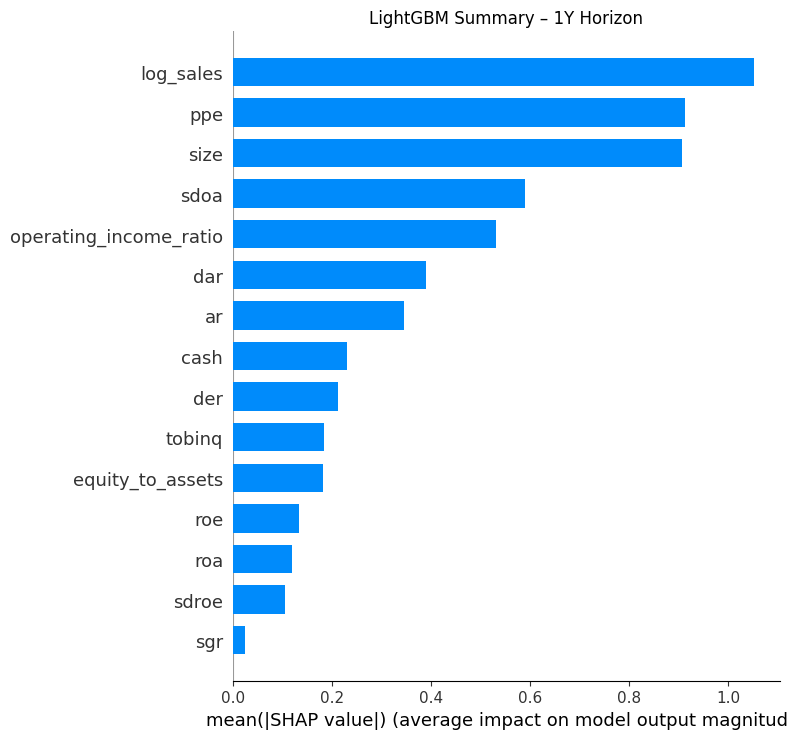


=== TEST 2Y (thr=0.4) ===
Accuracy : 0.8333333333333334
ROC-AUC  : 0.9075912304506177
PR-AUC   : 0.7189772140787457
Confusion matrix:
 [[180  29]
 [ 17  50]]
              precision    recall  f1-score   support

           0     0.9137    0.8612    0.8867       209
           1     0.6329    0.7463    0.6849        67

    accuracy                         0.8333       276
   macro avg     0.7733    0.8038    0.7858       276
weighted avg     0.8455    0.8333    0.8377       276

Type I Error : 0.2537313432835821
Type II Error: 0.13875598086124402
Recall       : 0.746268656716418


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


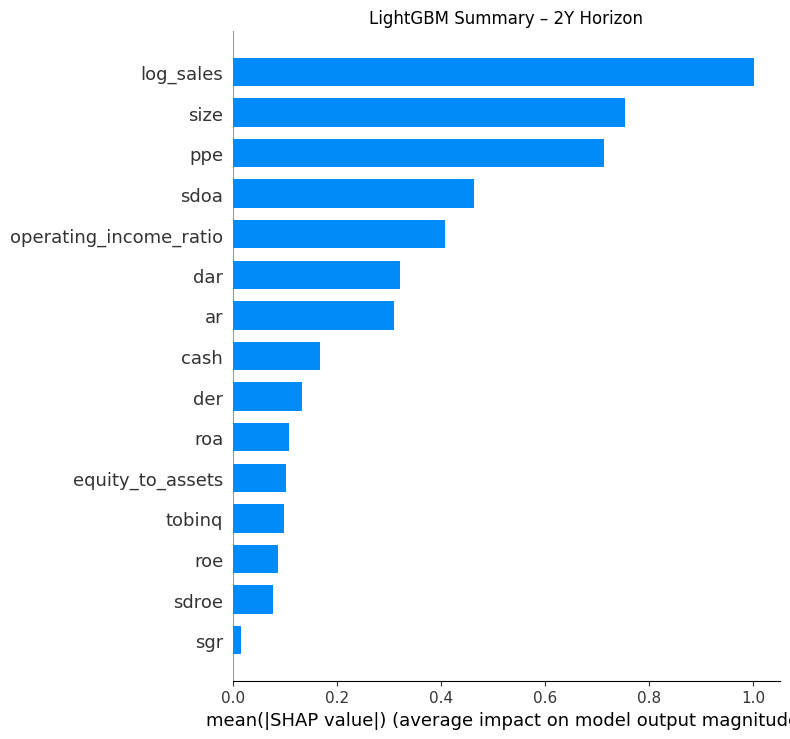


=== TEST 3Y (thr=0.4) ===
Accuracy : 0.8391304347826087
ROC-AUC  : 0.8986042692939245
PR-AUC   : 0.6993034274847012
Confusion matrix:
 [[150  24]
 [ 13  43]]
              precision    recall  f1-score   support

           0     0.9202    0.8621    0.8902       174
           1     0.6418    0.7679    0.6992        56

    accuracy                         0.8391       230
   macro avg     0.7810    0.8150    0.7947       230
weighted avg     0.8524    0.8391    0.8437       230

Type I Error : 0.23214285714285715
Type II Error: 0.13793103448275862
Recall       : 0.7678571428571429


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


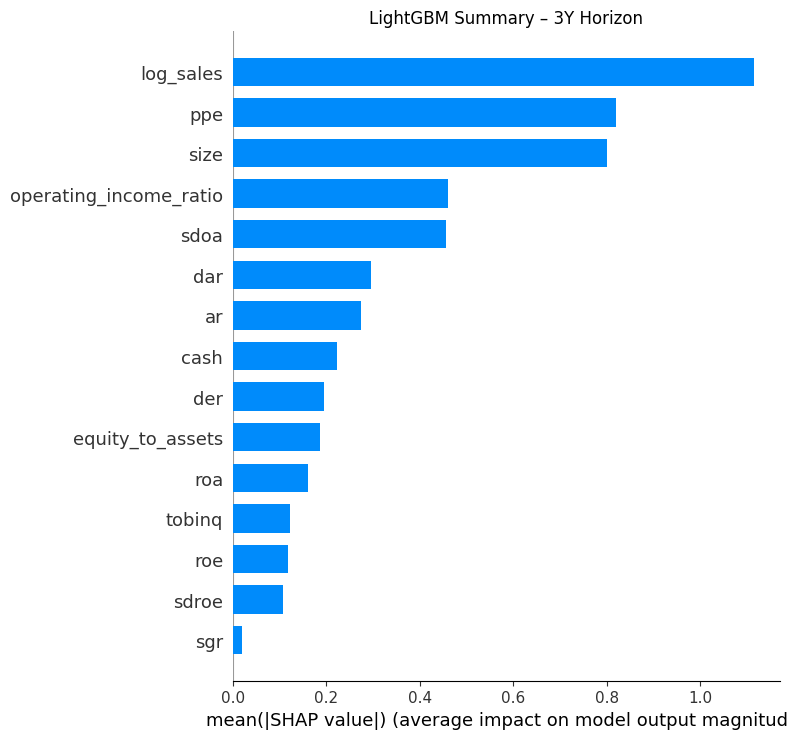


=== TEST 4Y (thr=0.4) ===
Accuracy : 0.8369565217391305
ROC-AUC  : 0.9090327737809752
PR-AUC   : 0.7588669222582446
Confusion matrix:
 [[117  22]
 [  8  37]]
              precision    recall  f1-score   support

           0     0.9360    0.8417    0.8864       139
           1     0.6271    0.8222    0.7115        45

    accuracy                         0.8370       184
   macro avg     0.7816    0.8320    0.7990       184
weighted avg     0.8605    0.8370    0.8436       184

Type I Error : 0.17777777777777778
Type II Error: 0.15827338129496402
Recall       : 0.8222222222222222


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


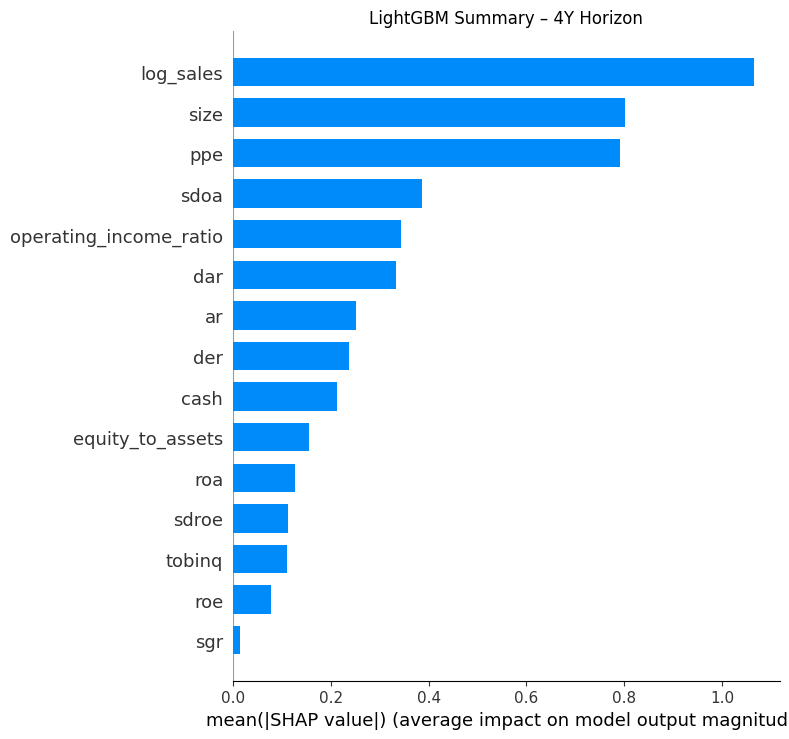


=== TEST 5Y (thr=0.4) ===
Accuracy : 0.8115942028985508
ROC-AUC  : 0.8942307692307692
PR-AUC   : 0.6800034287827705
Confusion matrix:
 [[84 20]
 [ 6 28]]
              precision    recall  f1-score   support

           0     0.9333    0.8077    0.8660       104
           1     0.5833    0.8235    0.6829        34

    accuracy                         0.8116       138
   macro avg     0.7583    0.8156    0.7745       138
weighted avg     0.8471    0.8116    0.8209       138

Type I Error : 0.17647058823529413
Type II Error: 0.19230769230769232
Recall       : 0.8235294117647058


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


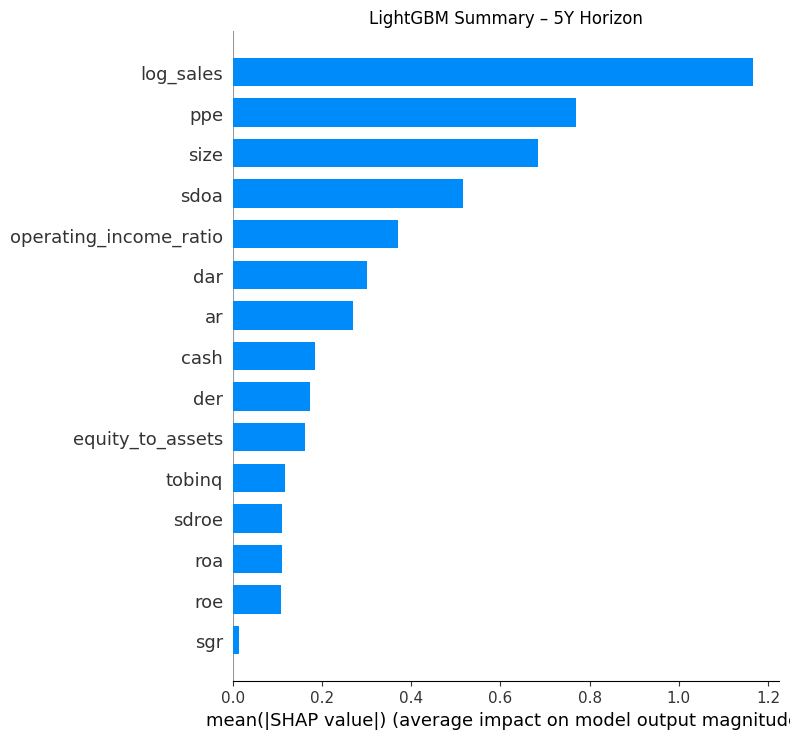

In [8]:
# ============================
# Evaluate and SHAP Plotting
# ============================

for h in [1, 2, 3, 4, 5]:
    # evaluate_rf_model(rf_models[h])

    eval_gb_split(
        name=f"TEST {h}Y",
        model=gb_models[h]["model"],
        X=gb_models[h]["X_test"],
        y=gb_models[h]["y_test"],

        # HARDCODE TUNING TRESHOLD
        # thr=rf_models[h]["threshold"]
        thr=0.4,
        model_type="lgbm"
    )
    
    plot_shap_for_horizon(
        model_dict=gb_models[h],
        feature_cols=feature_cols,
        model_type="lgbm",
        plot_type="bar"
    )

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


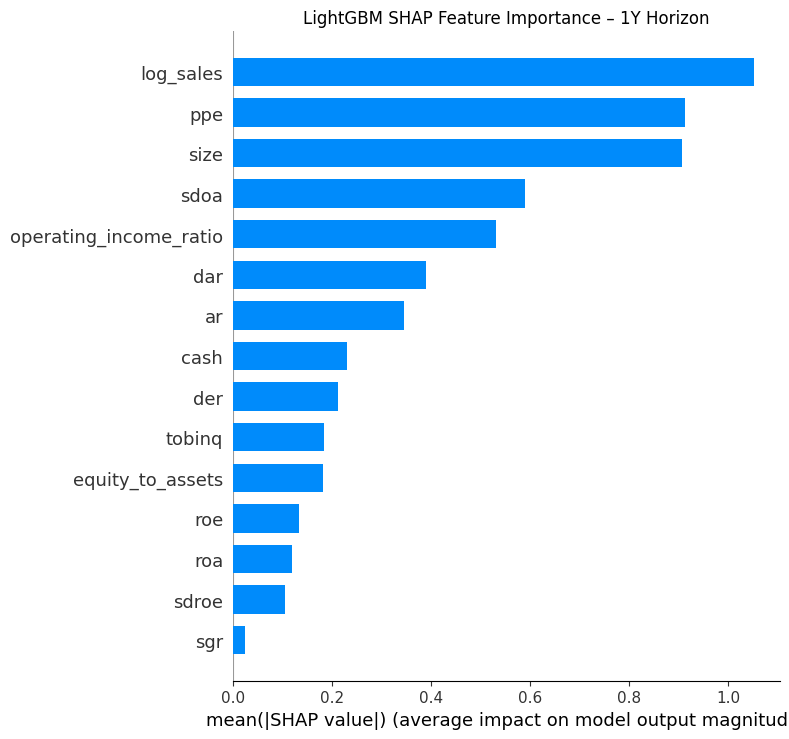

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


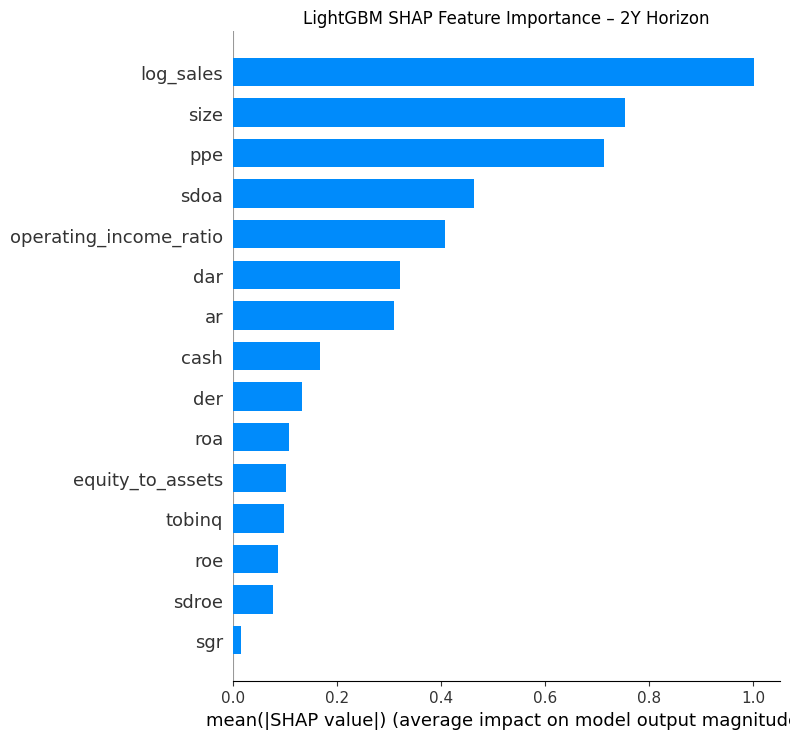

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


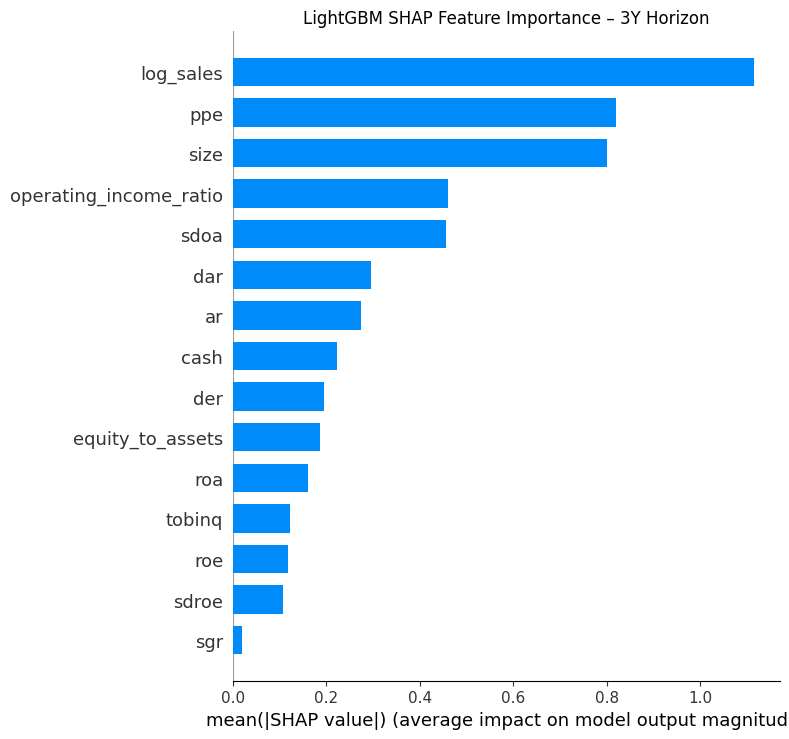

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


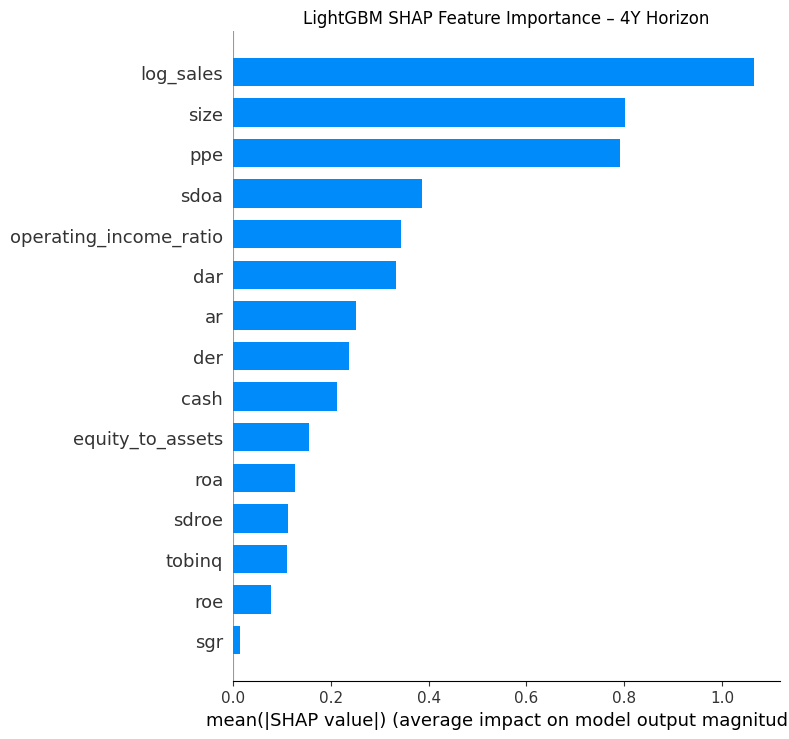

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


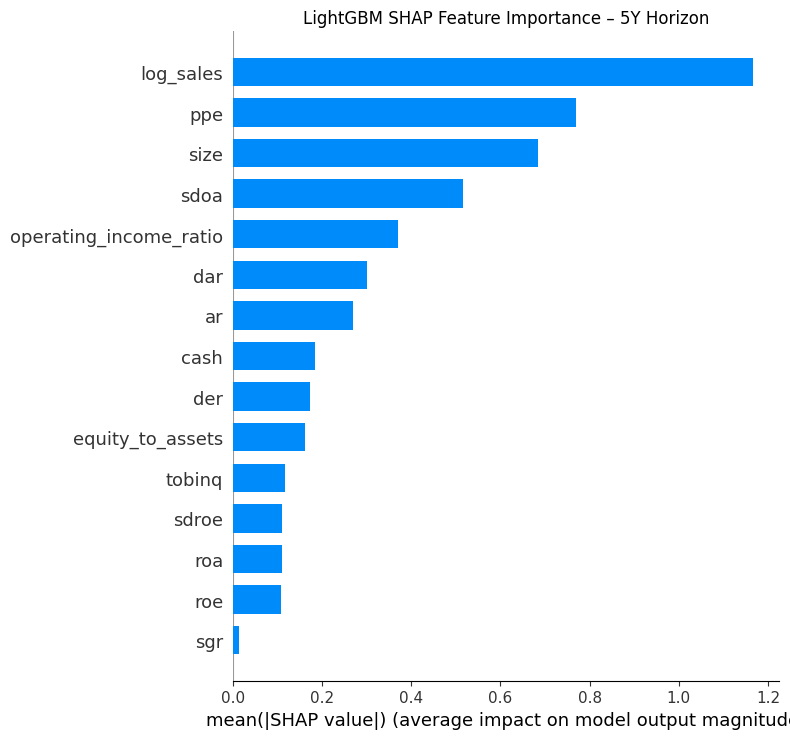

In [9]:
def plot_shap_feature_importance(
    model_dict,
    feature_cols,
    model_type="xgb",
    sample_n=500
):
    X_train = model_dict["X_train"]
    horizon = model_dict["horizon"]

    X_shap = X_train.sample(
        n=min(sample_n, len(X_train)),
        random_state=42
    )

    if model_type == "xgb":
        import xgboost as xgb
        
        booster = model_dict["booster"]
        dshap = xgb.DMatrix(X_shap)

        explainer = shap.TreeExplainer(booster)
        shap_values = explainer.shap_values(dshap)

        title = f"XGBoost SHAP Feature Importance – {horizon}Y Horizon"

    elif model_type == "rf":
        rf = model_dict["model"]
        explainer = shap.TreeExplainer(rf)
        shap_values = explainer.shap_values(X_shap)[1]  # class 1

        title = f"Random Forest SHAP Feature Importance – {horizon}Y Horizon"

    elif model_type == "lgbm":
        booster = model_dict["model"]  # LightGBM Booster

        explainer = shap.TreeExplainer(booster)
        shap_values_raw = explainer.shap_values(X_shap)

        shap_values = (
            shap_values_raw[1]
            if isinstance(shap_values_raw, list)
            else shap_values_raw
        )

        title = f"LightGBM SHAP Feature Importance – {horizon}Y Horizon"

    elif model_type == "ngboost":
        raise NotImplementedError(
            "NGBoost is not compatible with SHAP TreeExplainer. "
            "Feature importance should be discussed using alternative methods."
        )
        
    else:
        raise ValueError("model_type must be 'xgb', 'rf', 'lgbm', or 'ngboost'")

    
    if not isinstance(shap_values, np.ndarray) or shap_values.ndim != 2:
        raise ValueError(
            f"SHAP values must be 2D array (n_samples, n_features), "
            f"got {type(shap_values)} {getattr(shap_values, 'shape', None)}"
        )

    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        shap_values,
        X_shap,
        feature_names=feature_cols,
        plot_type="bar",
        show=False
    )
    plt.title(title)
    plt.tight_layout()
    plt.show()


for h in [1, 2, 3, 4, 5]:
    plot_shap_feature_importance(gb_models[h], feature_cols, model_type="lgbm")

In [10]:
# ============================
# SHAP Dependence Plot (Per Horizon)
# ============================

import shap
import xgboost as xgb
import matplotlib.pyplot as plt

top_features = [
    "log_sales",
    "ppe",
    "size",
    "operating_income_ratio",
    "dar",
    "sdoa",
]

def plot_shap_dependence(
    model_dict,
    top_features,
    model_type="xgb",      # "xgb", "rf", "lgbm"
    sample_n=500
):
    """
    SHAP dependence plot for XGBoost, Random Forest, or LightGBM (per horizon)
    """

    horizon = model_dict["horizon"]
    X_train = model_dict["X_train"]

    print(f"\nSHAP Dependence – {model_type.upper()} {horizon}Y Horizon")

    # ============================
    # Sampling
    # ============================
    X_sample = X_train.sample(
        n=min(sample_n, len(X_train)),
        random_state=42
    )

    # ============================
    # SHAP values
    # ============================
    if model_type == "xgb":
        booster = model_dict["model"]
        dshap = xgb.DMatrix(X_sample)

        explainer = shap.TreeExplainer(booster)
        shap_values = explainer.shap_values(dshap)

        title_prefix = "XGBoost"

    elif model_type in ["rf", "lgbm"]:
        model = model_dict["model"]

        explainer = shap.TreeExplainer(model)
        shap_values_raw = explainer.shap_values(X_sample)

        shap_values = (
            shap_values_raw[1]
            if isinstance(shap_values_raw, list)
            else shap_values_raw
        )

        title_prefix = (
            "Random Forest" if model_type == "rf" else "LightGBM"
        )

    else:
        raise ValueError("model_type must be 'xgb', 'rf', or 'lgbm'")

    # ============================
    # Dependence plots
    # ============================
    for feat in top_features:
        if feat not in X_sample.columns:
            continue

        plt.figure(figsize=(6, 4))
        shap.dependence_plot(
            feat,
            shap_values,
            X_sample,
            show=False
        )
        plt.title(f"{feat} – {title_prefix} SHAP ({horizon}Y)")
        plt.tight_layout()
        plt.show()


SHAP Dependence – LGBM 1Y Horizon


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


<Figure size 600x400 with 0 Axes>

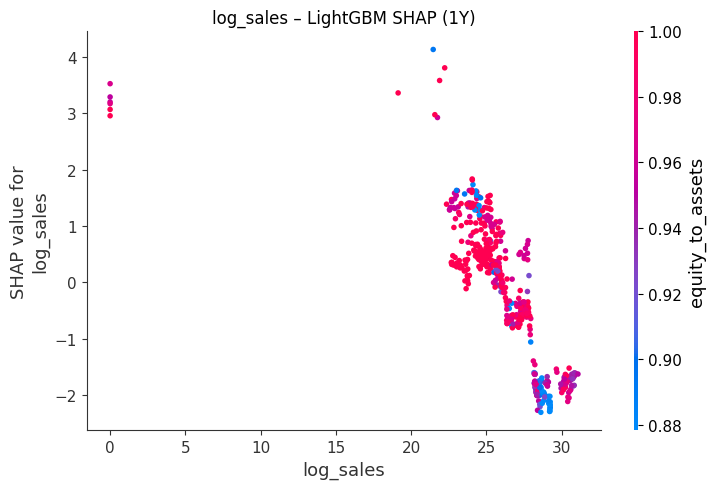

<Figure size 600x400 with 0 Axes>

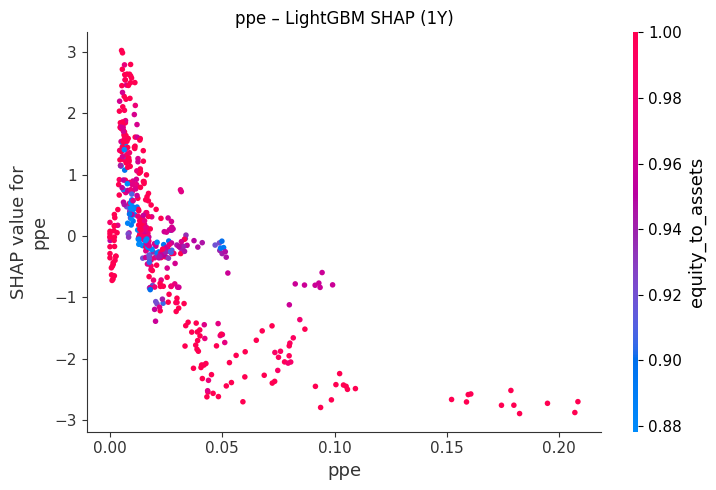

<Figure size 600x400 with 0 Axes>

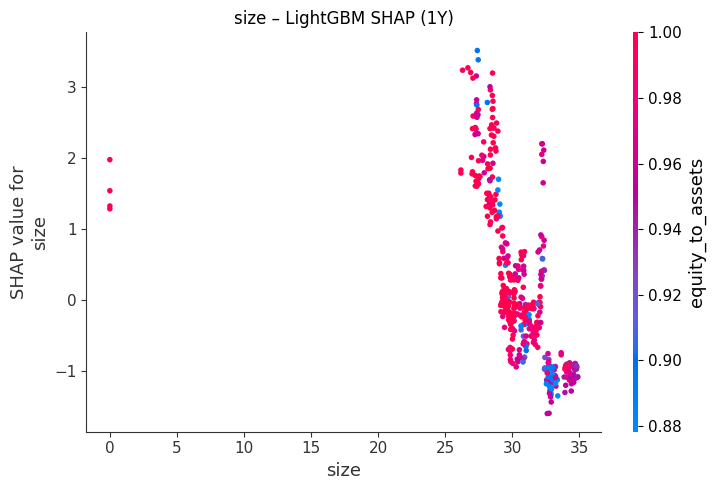

<Figure size 600x400 with 0 Axes>

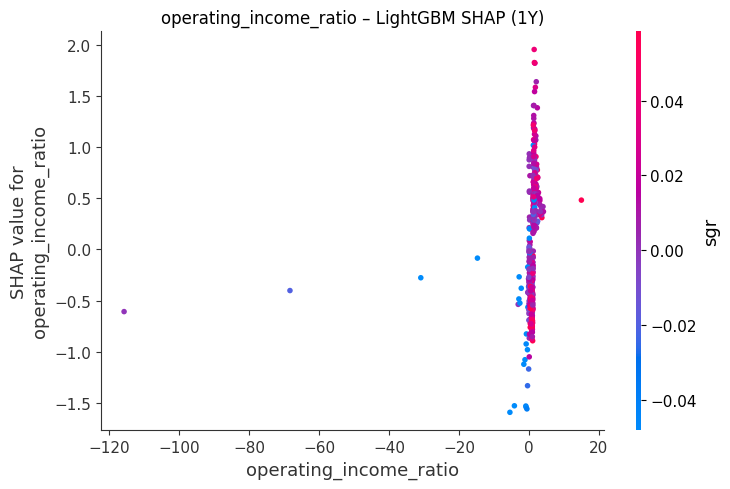

<Figure size 600x400 with 0 Axes>

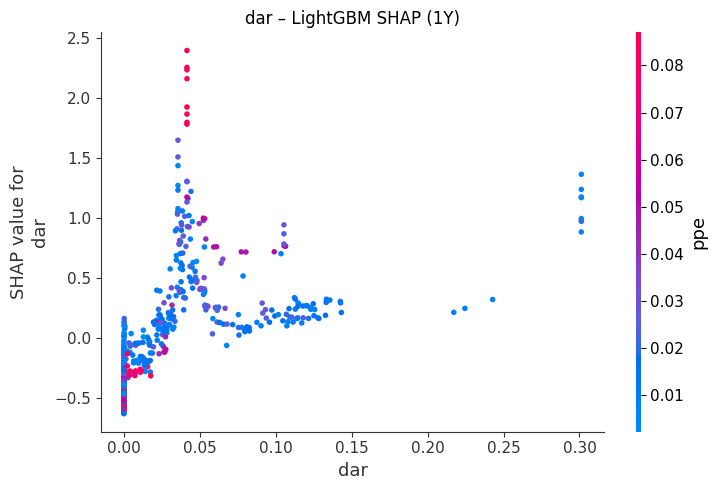

<Figure size 600x400 with 0 Axes>

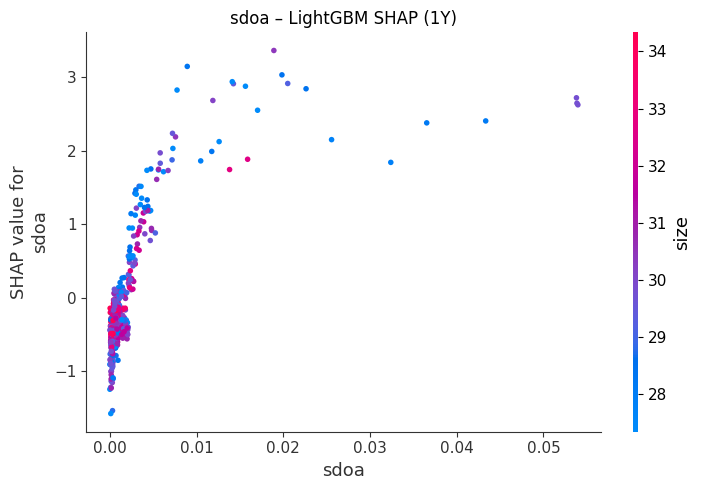


SHAP Dependence – LGBM 2Y Horizon


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


<Figure size 600x400 with 0 Axes>

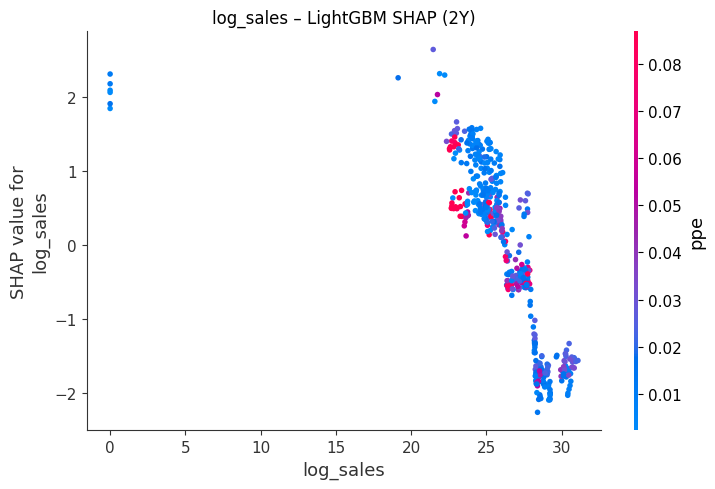

<Figure size 600x400 with 0 Axes>

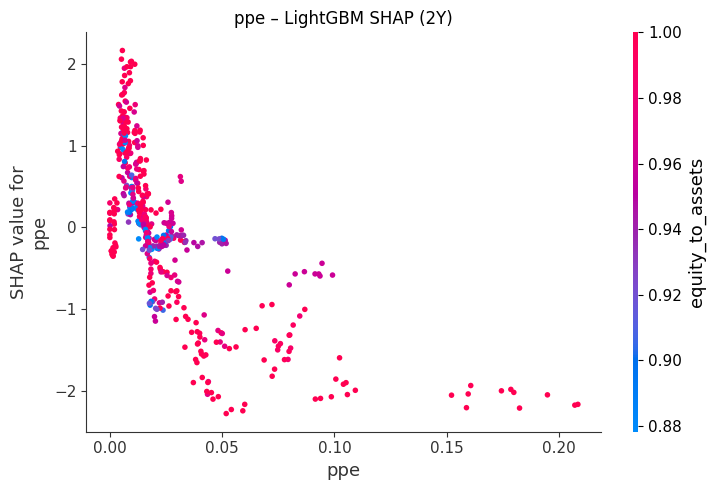

<Figure size 600x400 with 0 Axes>

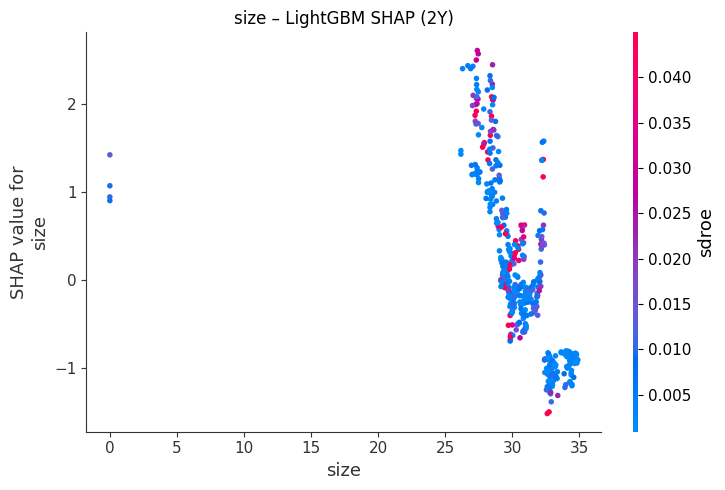

<Figure size 600x400 with 0 Axes>

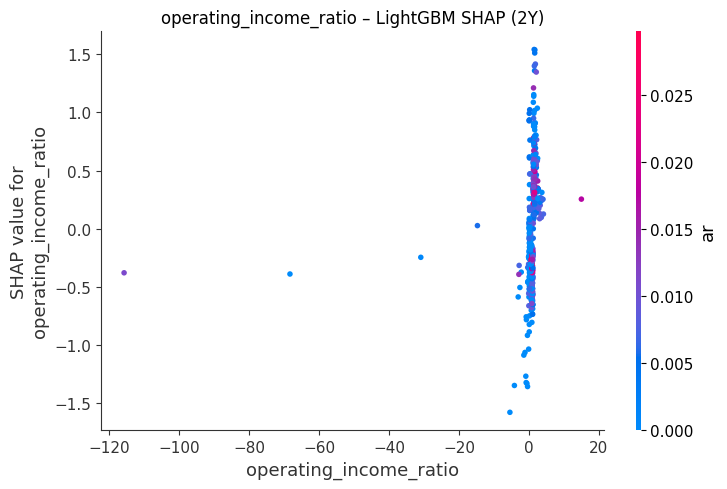

<Figure size 600x400 with 0 Axes>

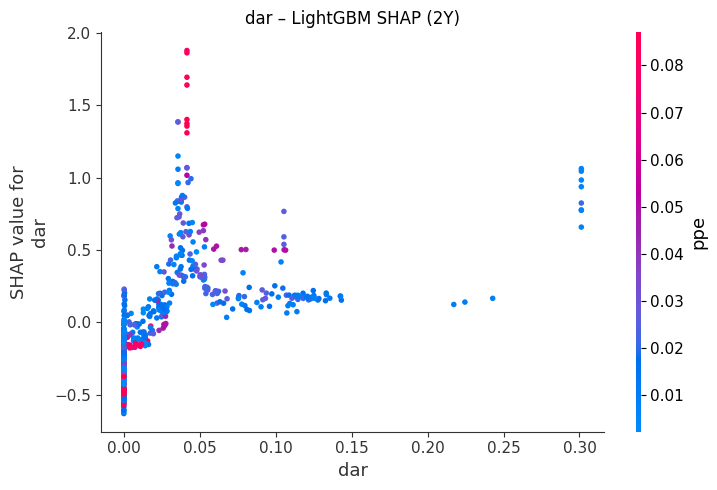

<Figure size 600x400 with 0 Axes>

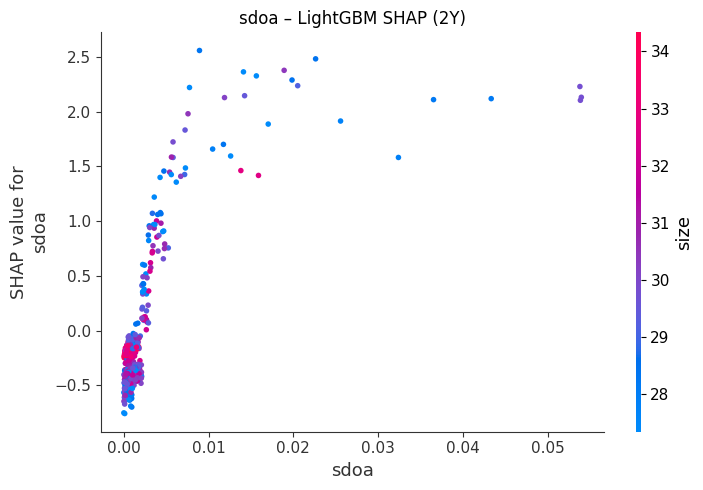


SHAP Dependence – LGBM 3Y Horizon


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


<Figure size 600x400 with 0 Axes>

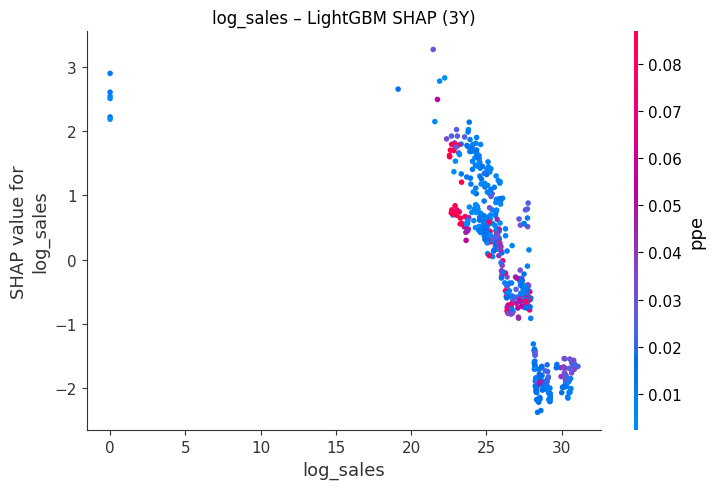

<Figure size 600x400 with 0 Axes>

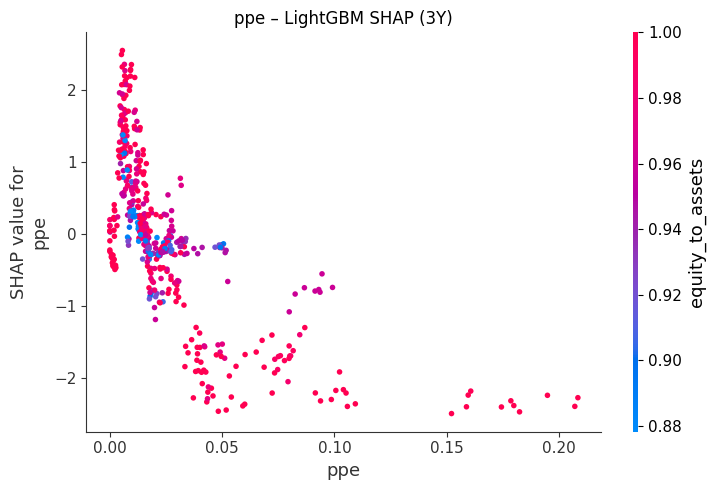

<Figure size 600x400 with 0 Axes>

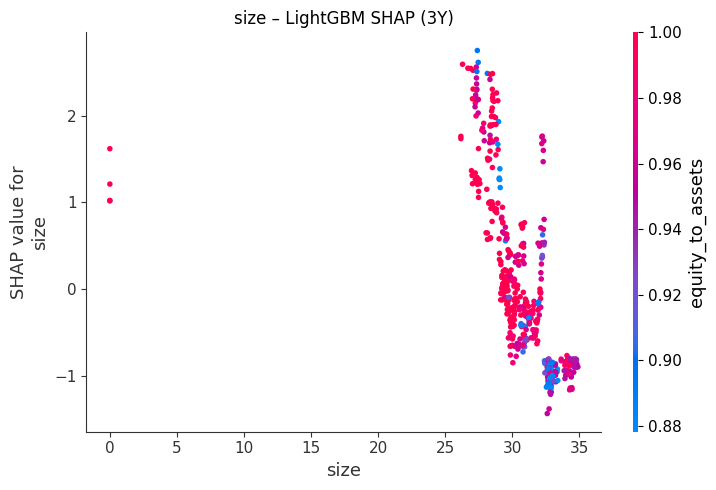

<Figure size 600x400 with 0 Axes>

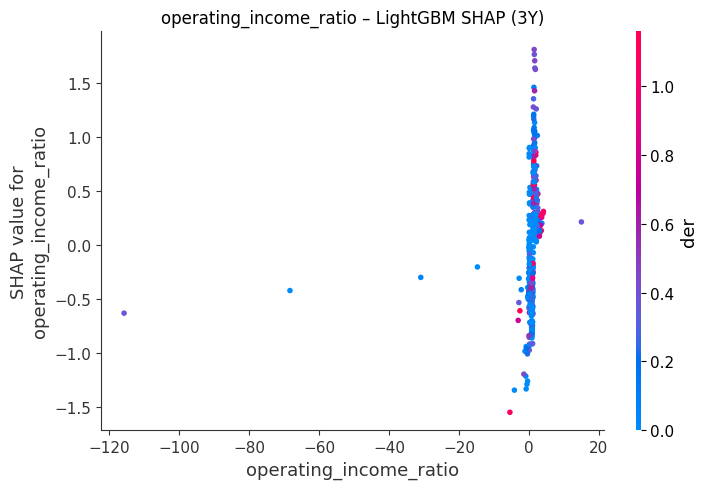

<Figure size 600x400 with 0 Axes>

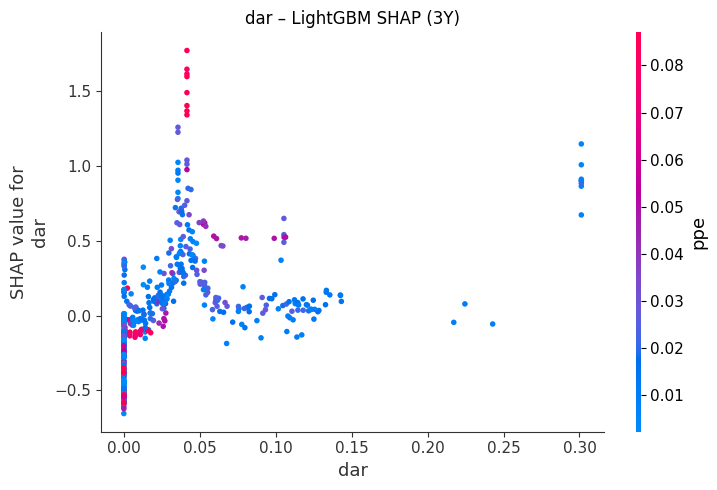

<Figure size 600x400 with 0 Axes>

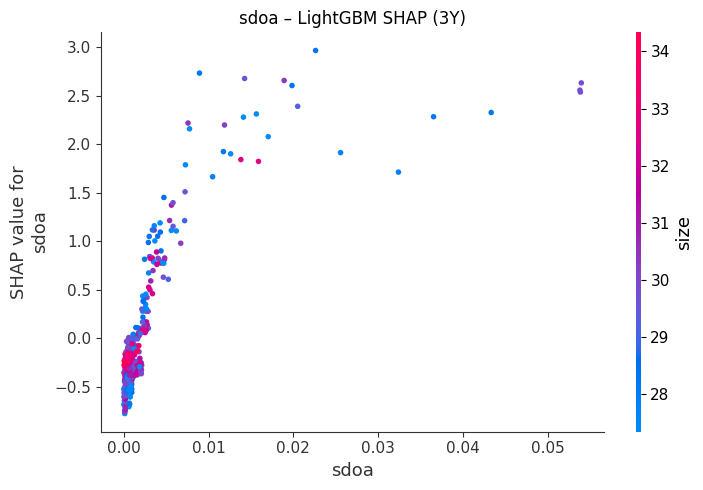


SHAP Dependence – LGBM 4Y Horizon


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


<Figure size 600x400 with 0 Axes>

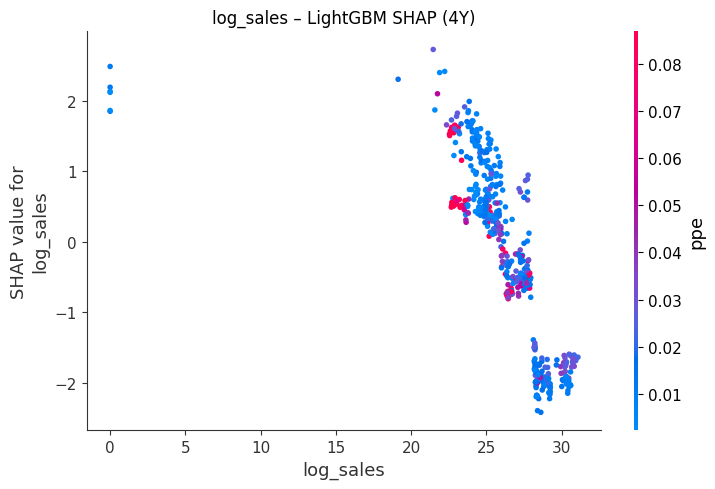

<Figure size 600x400 with 0 Axes>

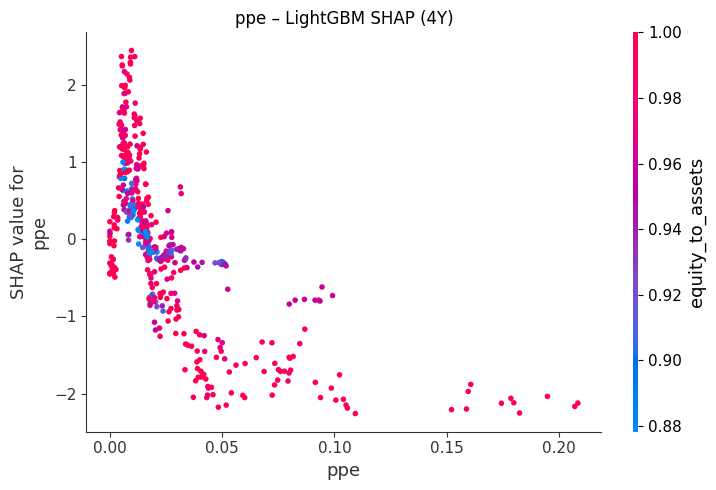

<Figure size 600x400 with 0 Axes>

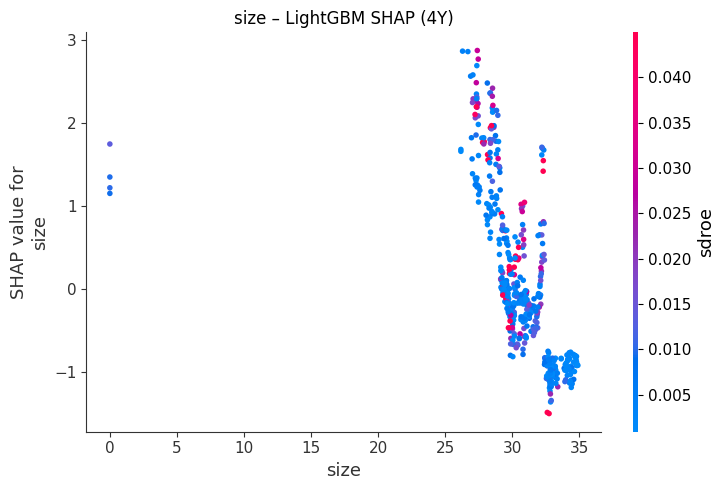

<Figure size 600x400 with 0 Axes>

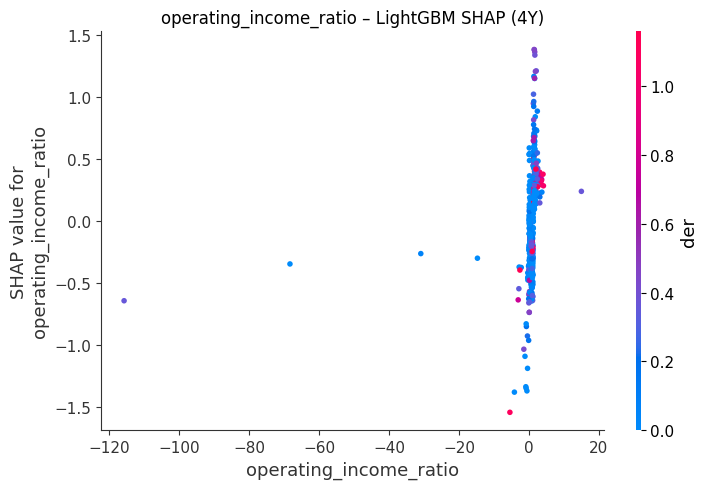

<Figure size 600x400 with 0 Axes>

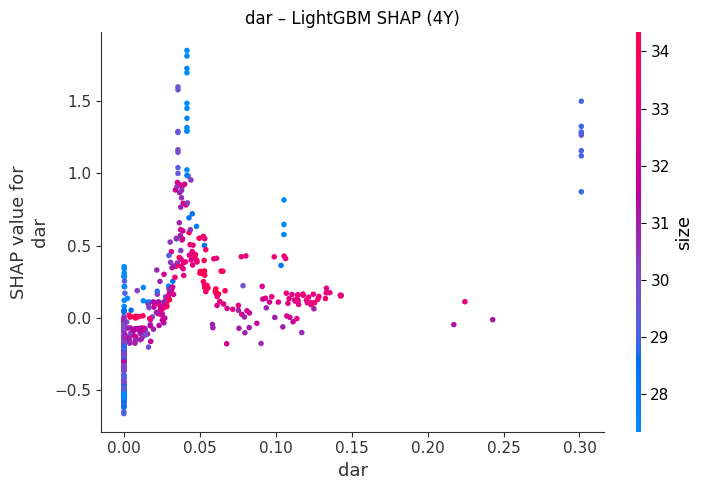

<Figure size 600x400 with 0 Axes>

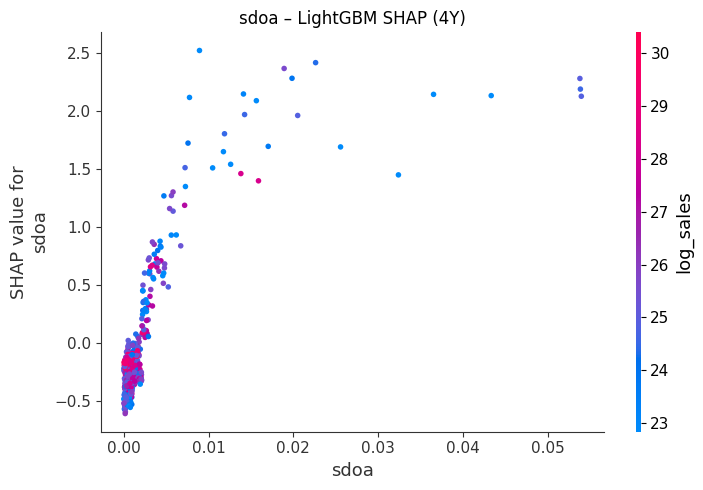


SHAP Dependence – LGBM 5Y Horizon


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


<Figure size 600x400 with 0 Axes>

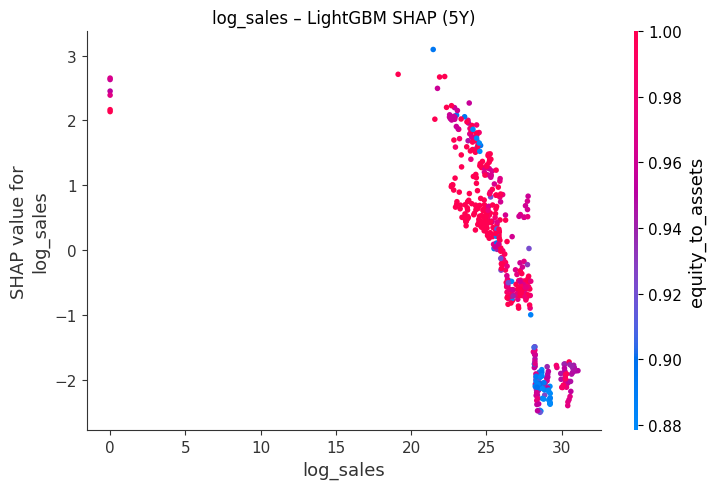

<Figure size 600x400 with 0 Axes>

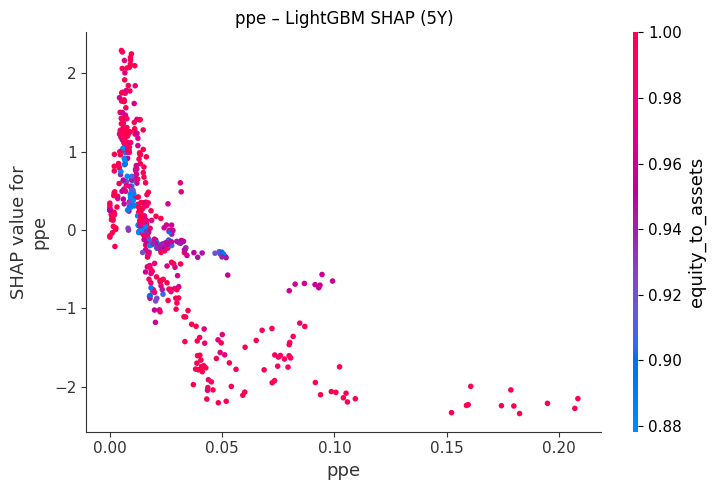

<Figure size 600x400 with 0 Axes>

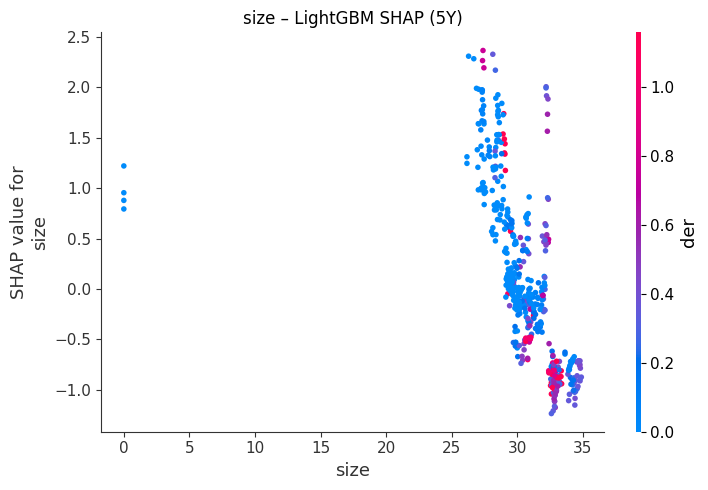

<Figure size 600x400 with 0 Axes>

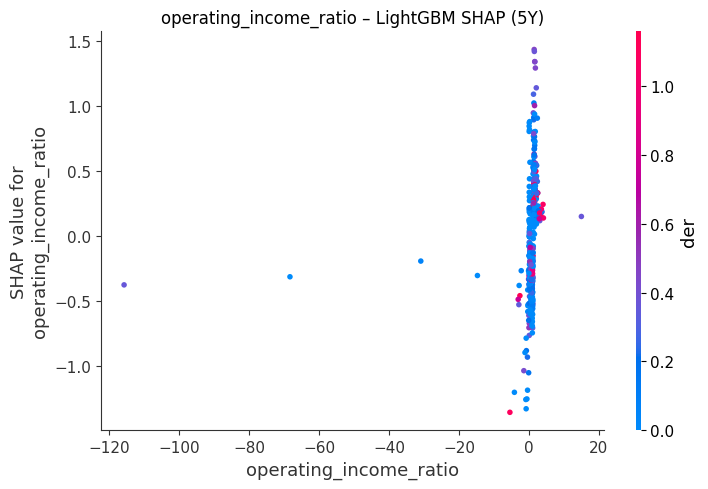

<Figure size 600x400 with 0 Axes>

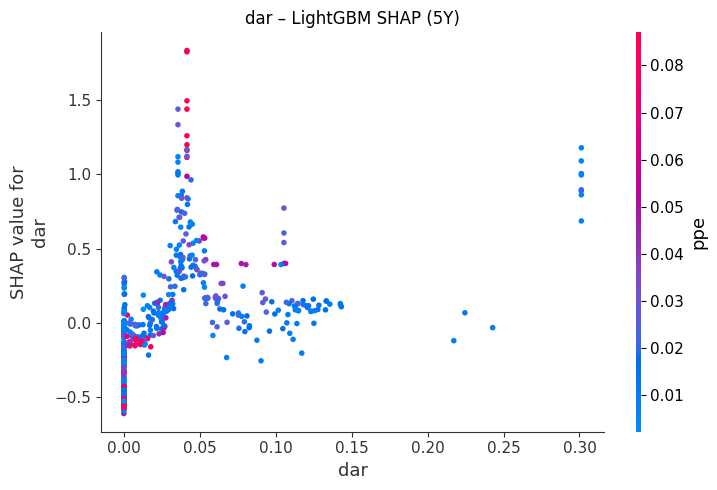

<Figure size 600x400 with 0 Axes>

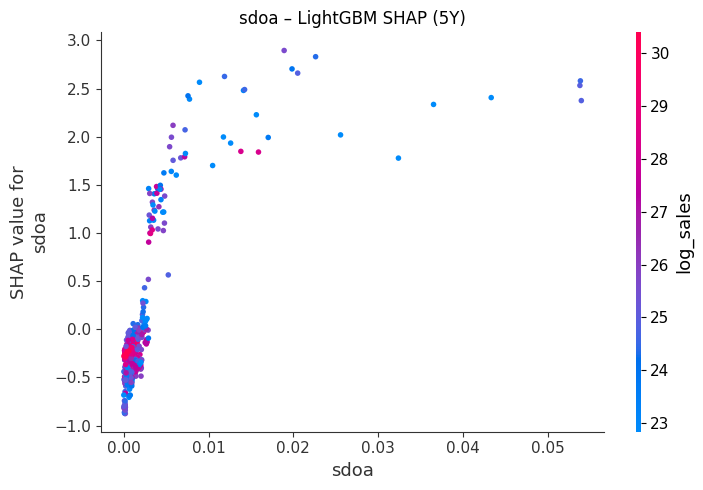

In [11]:
for h in [1, 2, 3, 4, 5]:
    plot_shap_dependence(
        model_dict=gb_models[h],
        top_features=top_features,
        model_type="lgbm"
    )